In [1]:
from __future__ import division
import re
from collections import Counter
import pickle
import numpy as np
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import jieba, re
import time
from sklearn.utils.extmath import randomized_svd


from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

import json

## data dictionary

In [23]:
path = '/media/external_3TB/3TB/rafie/master/model-inputs'
dataset = 'twitter'
split = 'validation'

f = open(f'{path}/{dataset}/{split}.txt', "r")
lines = f.readlines()
f.close()

events = {}
for line in tqdm(lines):
    line = json.loads(line.strip())
    events[str(line[0]['eid'])] = {'label' : line[1]}
    
def process_tweet(tweet):
#     return tweet['t'], tweet['uid'], tweet['text']
    t = int(time.mktime(time.strptime(tweet['created_at'],"%a %b %d %H:%M:%S +0000 %Y")))
    uid = tweet['user']['id']
    text = tweet['text']
    return t, uid, text
    

path = f'/media/external_3TB/3TB/rafie/master/{dataset}-raw-data/{dataset.capitalize()}'
for event in tqdm(events):
    timestamps = []
    uids = []
    texts = []
    
    for file in os.listdir(f"{path}/{event}-{events[event]['label']}"):
        file = json.load(open(f'{path}/{event}-{events[event]["label"]}/{file}'))
#     tweets = json.load(open(f'{path}/{event}.json'))
        for tweet in [file['tweet']] + file['retweets']:
            t, uid, text = process_tweet(tweet)
            timestamps.append(t) #
            uids.append(uid)    # tweet['user_id']
            texts.append(text)
        
    events[event]['timestamps'] = timestamps
    events[event]['uid'] = uids
    events[event]['text'] = texts
    

## user features

In [24]:
cnt = Counter()
for event in events:
    cnt.update(events[event]['uid'])

topk = 20000
top_users = list(map(lambda x: x[0], cnt.most_common(topk)))
all_users = list(map(lambda x: x[0], cnt.most_common()))

In [25]:
top_users_index = {}
for ii, uid in enumerate(top_users):
    top_users_index[uid] = ii

all_users_index = {}
for ii, uid in enumerate(all_users):
    all_users_index[uid] = ii
    
events_index = {}
for ii, eid in enumerate(events):
    events_index[eid] = ii

In [26]:
from scipy.sparse import csr_matrix

def get_user_in_event(eid, users):
    event_users = set(events[eid]['uid'])
    return list(set(users).intersection(event_users))

def get_user_event_matrix(users, users_index):
    row = []
    col = []
    data = []
    for ii, (eid, value) in tqdm(enumerate(events.items())):
        user_in_event = get_user_in_event(eid, users)
        for uid in user_in_event:
            uind = users_index[uid]
            col.append(ii)
            row.append(uind)
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(len(users), len(events)))

sub_matrix = get_user_event_matrix(top_users, top_users_index)
main_matrix = get_user_event_matrix(all_users, all_users_index)

print("top_users_events_matrix shape : {}".format(sub_matrix.shape))
print("Sparsity : {:.3f} %".format(sub_matrix.count_nonzero()/np.prod(sub_matrix.shape) * 100))
print("matrix_main shape: {}".format(main_matrix.shape))
print("Sparsity : {:.3f} % ".format(main_matrix.count_nonzero()/np.prod(main_matrix.shape) * 100))


top_users_events_matrix shape : (20000, 78)
Sparsity : 1.616 %
matrix_main shape: (39948, 78)
Sparsity : 1.449 % 


In [27]:
RELOAD = False
save_path = f'assets/{dataset}/{split}'
os.makedirs(save_path, exist_ok=True)

if RELOAD:
    
    u_main = np.load(open(f'{save_path}/u_main.npy','rb'))
    sigma_main = np.load(open(f'{save_path}/sigma_main.npy','rb'))
    vt_main = np.load(open(f'{save_path}/vt_main.npy','rb'))
    all_users_features = u_main@np.diag(sigma_main)
    
    u_sub = np.load(open(f'{save_path}/u_sub.npy','rb'))
    sigma_sub = np.load(open(f'{save_path}/sigma_sub.npy','rb'))
    vt_sib = np.load(open(f'{save_path}/vt_sub.npy','rb'))
    top_users_features = u_sub@np.diag(sigma_sub)
else:
    num_main_features = 20     # 10 for weibo, 20 for tweet
    n_iter = 7              # 15 for weibo,  7 for tweet
    
    u_main, sigma_main, vt_main = randomized_svd(main_matrix, n_components=num_main_features, n_iter=n_iter, random_state=42)
    all_users_features = u_main@np.diag(sigma_main)
    
    
    num_sub_features = 50
    
    u_sub, sigma_sub, vt_sub = randomized_svd(sub_matrix@sub_matrix.T, n_components=num_sub_features, n_iter=n_iter, random_state=42)  # random_state=42
    top_users_features = u_sub@np.diag(sigma_sub)
        
    np.save(f'{save_path}/u_main.npy',u_main)
    np.save(f'{save_path}/sigma_main.npy',sigma_main)
    np.save(f'{save_path}/vt_main.npy',vt_main)
    
    np.save(f'{save_path}/u_sub.npy',u_sub)
    np.save(f'{save_path}/sigma_sub.npy',sigma_sub)
    np.save(f'{save_path}/vt_sub.npy',vt_sub)

In [28]:
all_users_features.shape, top_users_features.shape

((39948, 20), (20000, 50))

## text features

In [8]:
binsize = 3600
threshold = 120*24
chinese_stopwords = '、 。 〃 〄 々 〆 〇 〈〉 《 》 「 」 『 』 【】 〒 〓 〔 〕 〖 〗 〘〙 〚 〛 〛 〜 〝 〞 〟，'
rx = '[' + re.escape(''.join(chinese_stopwords.split())) + ']'


def get_sentences():
    sentences = []
    for eid in tqdm(events):
        ts = sorted(events[eid]['timestamps'])
        cnt, bins = np.histogram(ts, bins=range(ts[0],ts[0]+threshold*binsize,binsize))

        nonzero_bins_ind = np.nonzero(cnt)[0]
        nonzero_bins = bins[nonzero_bins_ind]
        hist = cnt[nonzero_bins_ind]
        inv = nonzero_bins_ind[1:]-nonzero_bins_ind[:-1]
        intervals = np.insert(inv,0,0)

        for bid, bin_left in enumerate(nonzero_bins):
            bin_right = bin_left + binsize
            doc = ''
            for tid, t in enumerate(ts):
                if t<bin_left:
                    continue
                elif t>=bin_right:
                    break
                string = events[eid]['text'][tid]
                string = re.sub(r"http\S+", "", string)
                string = re.sub("[?!.,:;()'@#$%^&*-=+/\[\[\]\]]", ' ', string) # !.,:;()'@#$%^&*-_{}=+/\"
                doc += string
            sentences.append(TaggedDocument(
                words=doc, #jieba.lcut(doc), 
                tags=[eid+'_%s' % bid]
            ))
                
    return sentences
    
train_sentences = get_sentences()

print("train # sentences : {}".format(len(train_sentences)))


train # sentences : 66081


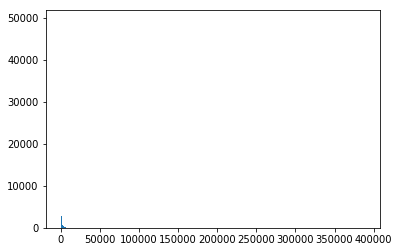

In [9]:
lens = [len(s.words) for s in train_sentences]
plt.hist(lens, 1000)
plt.show()

In [10]:
reload = False
if reload:
    doc_vectorizer = Doc2Vec.load(f'assets/{dataset}/doc2vec.model')
    print("doc_vectorizer is loaded.")
else:
    doc_vectorizer = Doc2Vec(min_count=1, window=10, vector_size=100, sample=1e-4, negative=5, workers=8)
    doc_vectorizer.build_vocab(train_sentences)
    print("build_vocab is done.")
    doc_vectorizer.train(train_sentences,total_examples=doc_vectorizer.corpus_count,epochs=10)
    print("doc2vec training is done.")
    doc_vectorizer.save(f'assets/{dataset}/doc2vec.model')

build_vocab is done.
doc2vec training is done.


## gather all features

In [29]:
threshold = 120*24
binsize = 3600

def get_event_features(eid):
    
    ## capture
    ts = sorted(events[eid]['timestamps'])
    cnt, bins = np.histogram(ts, bins=range(ts[0],ts[0]+threshold*binsize,binsize))

    nonzero_bins_ind = np.nonzero(cnt)[0]
    nonzero_bins = bins[nonzero_bins_ind]

    # num_engagements and time intervals
    hist = cnt[nonzero_bins_ind].reshape(-1,1)
    deltas = nonzero_bins_ind[1:]-nonzero_bins_ind[:-1]
    deltas = np.insert(deltas,0,0).reshape(-1, 1)
    
    # user features
    X_users = []
    for bid, bin_left in enumerate(nonzero_bins):
        bin_userlist = []
        bin_right = bin_left + binsize
        bin_user_feature = []
        for tid, t in enumerate(ts):
            if t<bin_left:
                continue
            elif t>=bin_right:
                break
            uind = all_users_index[events[eid]['uid'][tid]]
            bin_user_feature += [all_users_features[uind].reshape(1,-1)]   # (1,n_components)

        X_users += [np.concatenate(bin_user_feature, axis=0).mean(axis=0).reshape(1,-1)]
    X_users = np.concatenate(X_users, axis=0)
    
    # text features
    X_text = []
    for bid, bin_left in enumerate(nonzero_bins):
        bin_right = bin_left + binsize
        doc = ''
        for tid, t in enumerate(ts):
            if t<bin_left:
                continue
            elif t>=bin_right:
                break
            string = events[eid]['text'][tid]
            string = re.sub(r"http\S+", "", string)
            string = re.sub("[?!.,:;()'@#$%^&*-=+/\[\[\]\]]", ' ', string) # !.,:;()'@#$%^&*-_{}=+/\"
            doc += string
        X_text += [doc_vectorizer.infer_vector(
#             jieba.lcut(doc)
            doc
        ).reshape(1,-1)]
    X_text = np.concatenate(X_text, axis=0)
    
    # stack all
    X_capture = np.hstack([hist, deltas, X_users, X_text])
    
    ## score
    eind = events_index[eid]
    top_active_users = np.where(sub_matrix[:, eind].toarray() > 0)[0]
    X_score = top_users_features[top_active_users]
    
    ## label
    y = events[eid]['label']
    
    return X_capture, X_score, y

In [30]:
# xc, xs, y = get_event_features('9833726676')
# xc.shape, xs.shape, y

In [31]:
save_path = f'assets/{dataset}/{split}/pkls/'
os.makedirs(save_path, exist_ok=True)

for eid in tqdm(events):
    xc, xs, y = get_event_features(eid)
    pickle.dump(
        {'x_capture': xc, 'x_score':xs, 'label': y}, 
        open(save_path + eid + '.pkl', 'wb')
    )